<a href="https://colab.research.google.com/github/MattRazo/CIS4290-Image-Set-Models/blob/main/Image_Set_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#all the imports we most likely need
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib

In [ ]:
# Old Path for image set
animals = pathlib.Path('/content/gdrive/MyDrive/CIS4290_Group2_CNN/Animals')

In [ ]:
animals = pathlib.Path('/content/gdrive/MyDrive/Animals')

In [ ]:
image_count = len(list(animals.glob('*/*.jpg')))
print(image_count)

16130


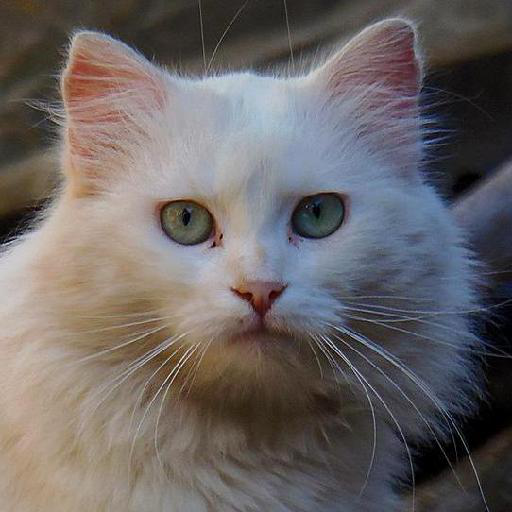

In [ ]:
cat = list(animals.glob('cat/*'))
PIL.Image.open(str(cat[0]))

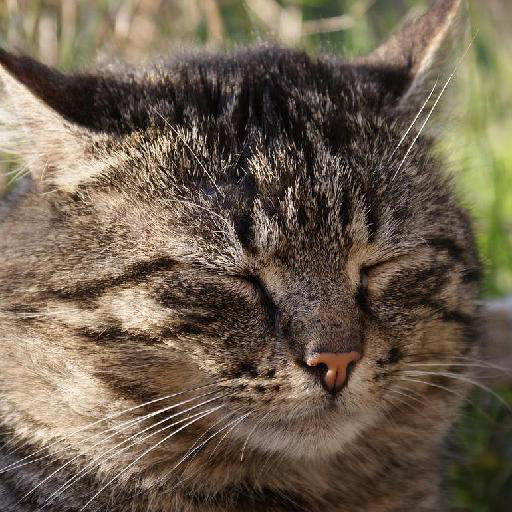

In [ ]:
PIL.Image.open(str(cat[1]))

In [ ]:
#Tried to adjust height and width like image set 2, however the colab file would run out of ram. possibly due to image quality
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  animals,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16130 files belonging to 3 classes.
Using 12904 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  animals,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16130 files belonging to 3 classes.
Using 3226 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog', 'wild']


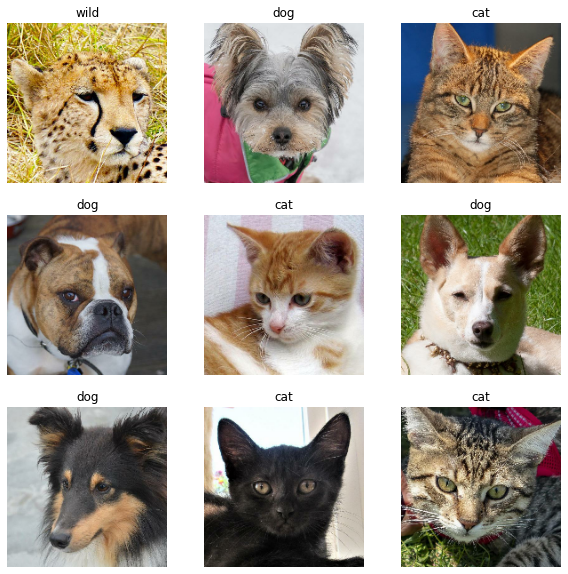

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
#This step is where Ram starts being consumed the most
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 260, 260, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 260, 260, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 130, 130, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 130, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 65, 65, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 65, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
404/404 [==============================] - 901s 2s/step - loss: 0.4041 - accuracy: 0.8341 - val_loss: 0.1793 - val_accuracy: 0.9349
Epoch 2/10
404/404 [==============================] - 418s 1s/step - loss: 0.1261 - accuracy: 0.9555 - val_loss: 0.1254 - val_accuracy: 0.9535
Epoch 3/10
404/404 [==============================] - 420s 1s/step - loss: 0.0705 - accuracy: 0.9744 - val_loss: 0.1113 - val_accuracy: 0.9597
Epoch 4/10
404/404 [==============================] - 416s 1s/step - loss: 0.0404 - accuracy: 0.9867 - val_loss: 0.1229 - val_accuracy: 0.9622
Epoch 5/10
404/404 [==============================] - 416s 1s/step - loss: 0.0312 - accuracy: 0.9883 - val_loss: 0.1293 - val_accuracy: 0.9594
Epoch 6/10
404/404 [==============================] - 415s 1s/step - loss: 0.0266 - accuracy: 0.9905 - val_loss: 0.1316 - val_accuracy: 0.9606
Epoch 7/10
404/404 [==============================] - 417s 1s/step - loss: 0.0215 - accuracy: 0.9925 - val_loss: 0.1313 - val_accuracy: 0.9616

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()